In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.widgets import RectangleSelector
import tkinter.filedialog as tkf
from scipy import optimize
import ipywidgets as pyw

In [11]:
# refer to https://scipy-cookbook.readthedocs.io/items/FittingData.html

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape) # row, col
    x = (X*data).sum()/total # row
    y = (Y*data).sum()/total # col
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum()) # row
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum()) # col
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [12]:
def gaussian_center(image, cbox_edge=0):
    y, x = np.indices(image.shape)
    if not cbox_edge:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    else:
        cbox_outy = int(image.shape[0]/2 - cbox_edge/2)
        cbox_outx = int(image.shape[1]/2 - cbox_edge/2)
        center_box = image[cbox_outy:-cbox_outy, cbox_outx:-cbox_outx]
        fit_params = fitgaussian(center_box)
        (_, center_y, center_x, _, _) = fit_params
        center = [center_y+cbox_outy, center_x+cbox_outx]
        
    return center

In [13]:
def remove_center_beam(image, center=None, cb_rad=0):
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0], x - center[1])
    r = np.around(r)
    ri = np.where(r<=cb_rad)
    #print(ri[0].shape)
    
    image[ri] = 0
    
    return image

In [14]:
# refer to github.com/mkolopanis/python/blob/master/radialProfile.py

def radial_variance(image, profile_resolution=1.0, center=None):
   
    y, x = np.indices(image.shape) * profile_resolution
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0]*profile_resolution, x - center[1]*profile_resolution)
    #plt.imshow(r, cmap="Accent")
    #plt.show()

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = np.around(r_sorted)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    csim = np.cumsum(i_sorted, dtype=float)
    sq_csim = np.cumsum(np.square(i_sorted), dtype=float)
    
    #plt.plot(np.square(csim), c="red")
    #plt.plot(sq_csim, c="blue")
    
    avg_square = np.square((csim[rind[1:]] - csim[rind[:-1]]) / nr)
    square_avg = (sq_csim[rind[1:]] - sq_csim[rind[:-1]]) / nr
    
    #plt.plot(avg_square[20:], c="red")
    #plt.plot(square_avg[20:], c="blue")
    
    mask = avg_square.copy()
    mask[np.where(avg_square==0)] = 1.0
    radial_var = (square_avg - avg_square) / mask
    
    return radial_var    

In [15]:
def load_binary_4D_stack(img_adr, datatype, original_shape, final_shape, log_scale=False):
    raw_stack = np.fromfile(img_adr, dtype=datatype)
    stack = raw_stack.reshape(original_shape)
    print(stack.shape)
    if log_scale:
        stack = np.log(stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]])
    else:
        stack = stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]]
    
    print(stack.shape) 
    return stack

In [16]:
raw_adr = tkf.askopenfilename()
print(raw_adr)

G:/내 드라이브/data_repository/4D/20190925_DGIST/raw_data/Bset3_3/scan_x256_y256.raw


In [17]:
datatype = "float32"
o_shape = (256, 256, 130, 128)
f_shape = (256, 256, 128, 128)

In [18]:
# load a data
stack_4d = load_binary_4D_stack(raw_adr, datatype, o_shape, f_shape, log_scale=False)
print(np.max(stack_4d))
print(np.min(stack_4d))
print(np.mean(stack_4d))
#print(np.median(stack_4d))

(256, 256, 130, 128)
(256, 256, 128, 128)
1121295.0
1170.0
5460.203


In [19]:
# select an interesting area
%matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.sum(stack_4d, axis=(2, 3)), cmap="gray")

def onselect(eclick, erelease):
    print('startposition: (%f, %f)' % (eclick.xdata, eclick.ydata))
    print('endposition  : (%f, %f)' % (erelease.xdata, erelease.ydata))

box = RectangleSelector(ax, onselect)
plt.show()

startposition: (99.045572, 81.741618)
endposition  : (150.296822, 132.992869)


In [20]:
# crop the data
stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()
print(stack_4d_cropped.shape)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
#print(np.median(stack_4d_cropped))

(51, 51, 128, 128)
432134.0
1249.0
4448.1543


In [21]:
%matplotlib inline

(51, 51, 2)
[64.45831387 65.12135581]


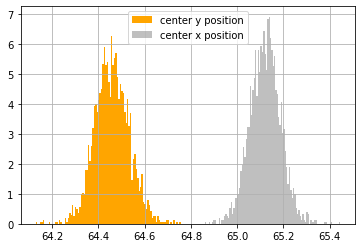

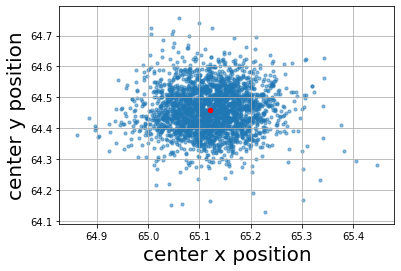

In [22]:
# find center position
center_pos = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        center_pos.append(gaussian_center(stack_4d_cropped[i, j], cbox_edge=30))
        
center_pos = np.asarray(center_pos)
center_pos = np.reshape(center_pos, (stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1))
print(center_pos.shape)
center_mean = np.mean(center_pos, axis=(0, 1))
print(center_mean)

# center distibution
plt.figure()
plt.hist(center_pos[:, :, 0].flatten(), bins=100, density=True, color="orange", label="center y position")
plt.hist(center_pos[:, :, 1].flatten(), bins=100, density=True, color="gray", alpha=0.5, label="center x position")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(center_pos[:, :, 1], center_pos[:, :, 0], s=10.0, alpha=0.5)
plt.grid()
plt.scatter(center_mean[1], center_mean[0], s=20, c="red")
plt.xlabel("center x position", fontsize=20)
plt.ylabel("center y position", fontsize=20)
plt.show()

In [23]:
# remove center beam
stack_4d_cropped_cb = stack_4d_cropped.copy()
center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
#print(np.median(stack_4d_cropped))

26760.0
0.0
2814.4524


(51, 51, 91)
(91,)


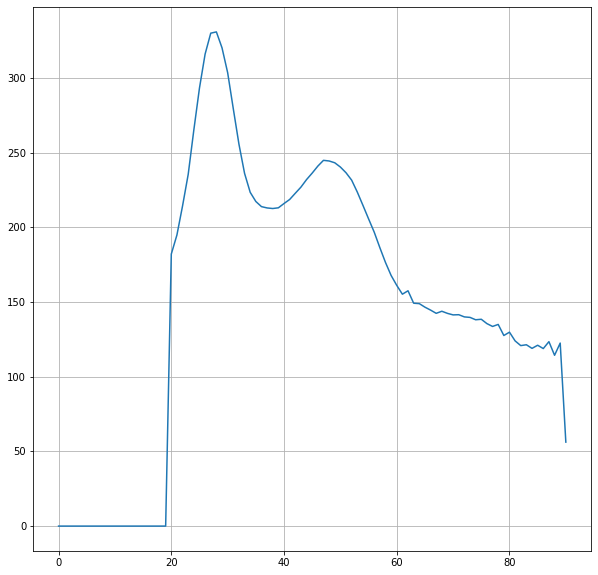

In [24]:
# calculate variance with all angles at a certain k
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

In [25]:
def radial_indices(shape, radial_range, center=None):
    y, x = np.indices(shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
    
    r = np.hypot(y - center[0], x - center[1])
    ri = np.ones(r.shape)
    
    if len(np.unique(radial_range)) > 1:
        ri[np.where(r <= radial_range[0])] = 0
        ri[np.where(r > radial_range[1])] = 0
        
    else:
        r = np.round(r)
        ri[np.where(r != round(radial_range[0]))] = 0
    
    return ri

In [26]:
%matplotlib qt
fig = plt.figure(figsize=(15, 5))
G = gridspec.GridSpec(2, 5)
ax0 = plt.subplot(G[0, 0])
ax1 = plt.subplot(G[0, 1])
ax2 = plt.subplot(G[0, 2])
ax3 = plt.subplot(G[1, 0])
ax4 = plt.subplot(G[1, 1])
ax5 = plt.subplot(G[1, 2])
ax6 = plt.subplot(G[:, 3:])

radii = np.arange(len(radial_var_sum))
#pacbed = np.mean(stack_4d_cropped, axis=(0, 1))
pacbed = np.log(np.mean(stack_4d_cropped_cb, axis=(0, 1)))
def var_selector(di, do, uth, lth, k1, k2, p1, p2):
    
    v1 = np.percentile(radial_var_stack[:, :, k1:(k2+1)], p1)
    v2 = np.percentile(radial_var_stack[:, :, k1:(k2+1)], p2)
    
    ax0.cla()
    ax1.cla()
    ax2.cla()
    ax3.cla()
    ax4.cla()
    ax5.cla()
    ax6.cla()

    ax0.plot(radii, radial_var_sum, "k-", c="black")
    ax0.fill_between([k1, k2], np.max(radial_var_sum), alpha=0.5, color="orange")
    ax0.grid()
    
    masked = radial_var_stack[:, :, k1:(k2+1)]
    binsize = masked.shape[0]*masked.shape[1]
    ax1.hist(masked.flatten(), bins=binsize, color="darkgray")
    ax1.fill_between([v1, v2], ax1.get_ylim()[1], alpha=0.5, color="orange")
    ax1.grid()
    
    bool_img = np.ones_like(masked)
    bool_img[np.where(masked < v1)] = 0
    bool_img[np.where(masked > v2)] = 0
    img = np.sum(bool_img, axis=2)
    ax2.imshow(img, cmap="afmhot")
    ax2.axis("off")
    
    if di > do:
        det = [do, di]
        print("Warning! detector 1 (inner angle > outer angle)")
    else:
        det = [di, do]
        
    ri = radial_indices(f_shape[2:], det, center=center_mean.tolist())
    stem = np.sum(np.multiply(stack_4d_cropped_cb, ri), axis=(2, 3))
    ax4.imshow(stem, cmap="afmhot")
    ax4.axis("off")
    
    stem_bool = np.ones_like(stem)
    stem_bool[np.where(stem > np.percentile(stem, uth))] = 0.0
    stem_bool[np.where(stem <= np.percentile(stem, lth))] = 0.0
    
    ax5.imshow(stem_bool, cmap="summer")
    ax5.axis("off")
    
    ax3.imshow(pacbed, cmap="gray")
    ax3.imshow(ri, cmap="Reds", alpha=0.3)
    ax3.axis("off")
    
    ax6.imshow(stem_bool, cmap="summer")
    ax6.imshow(img, cmap="afmhot", alpha=0.3)
    ax6.axis("off")
    
    fig.canvas.draw()
    fig.tight_layout()

st = {"description_width": "initial"}
din = pyw.IntText(value=25, description="D1 inner angle: ", style=st)
dout = pyw.IntText(value=30, description="D1 outer angle: ", style=st)
up_th = pyw.IntText(value=10, description="STEM upper threshold: ", style=st)
lo_th = pyw.IntText(value=0, description="STEM lower threshold: ", style=st)
k1_widget = pyw.IntText(value=25, description="left of k-range", style=st)
k2_widget = pyw.IntText(value=30, description="right of k-range", style=st)
p1_widget = pyw.FloatText(value=90.0, description="left percentile of variance range", style=st)
p2_widget = pyw.FloatText(value=99.999, description="right percentile of variance range", style=st)

pyw.interact(var_selector, di=din, do=dout, uth=up_th, lth=lo_th, k1=k1_widget, k2=k2_widget, p1=p1_widget, p2=p2_widget)
fig.show()

interactive(children=(IntText(value=25, description='D1 inner angle: ', style=DescriptionStyle(description_wid…